<a href="https://colab.research.google.com/github/seugminhama/portfolio/blob/main/Boost%20up%20AI%202025%3A%20%EC%8B%A0%EC%95%BD%20%EA%B0%9C%EB%B0%9C%20%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C/01_EDA/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 33.8 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.2 MB/s eta 0:00:00


In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/1

In [ ]:
# 기본 라이브러리
import pandas as pd
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import io
import warnings
warnings.filterwarnings("ignore")

# 화학 정보 처리(RDKit)
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import rdBase
rdBase.DisableLog("rdApp.error")

# 머신러닝
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from pycaret.regression import *

##Data Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 불러오기
train_path = '/content/drive/MyDrive/Boost up AI 2025/train.csv'
test_path = '/content/drive/MyDrive/Boost up AI 2025/test.csv'
submission = '/content/drive/MyDrive/Boost up AI 2025/sample_submission.csv'

In [ ]:
train = pd.read_csv(train_path)
train = train[['Canonical_Smiles', 'Inhibition']]

##EDA

In [ ]:
train.head()

,Canonical_Smiles,Inhibition
0,Cl.OC1(Cc2cccc(Br)c2)CCNCC1,12.50
1,Brc1ccc2OCCc3ccnc1c23,4.45
2,CC1(CO)CC(=NO1)c2cc(c(F)cc2Cl)[N+](=O)[O-],4.92
3,Fc1ccc2nc(Nc3cccc(COc4cccc(c4)C(=O)N5CCOCC5)c3...,71.50
4,CC(C)CC(=O)C1=C(Nc2c(Cl)ccc(Cl)c2C1=O)S(=O)C,18.30


In [ ]:
train.shape

(1681, 2)

In [ ]:
# 설명 가능한 수치 피처로 변환하는 과정
def extract_rdkit_features(smiles):
  try:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
      return [
          Descriptors.MolWt(mol),             # ① 분자량: 전체 질량. 무거운 분자는 효소와 결합 특성이 다름
          Descriptors.MolLogP(mol),           # ② LogP: 지용성 지표. 클수록 세포막 통과 잘함
          Descriptors.NumHAcceptors(mol),     # ③ 수소 수용자 수: 효소와 수소 결합 형성 가능성
          Descriptors.NumHDonors(mol),        # ④ 수소 기부자 수: 수소 제공 능력, 결합 안정성 영향
          Descriptors.TPSA(mol),              # ⑤ 극성 표면적: 극성 작용기의 표면적, 흡수율과 상관
          Descriptors.NumRotatableBonds(mol), # ⑥ 회전 가능한 결합 수: 분자의 유연성 (3D 구조 적응력)
          Descriptors.HeavyAtomCount(mol),    # ⑦ 무거운 원자 수: 수소 제외한 원자 수, 분자 크기/복잡도 판단
          Descriptors.FractionCSP3(mol),      # ⑧ sp3 탄소 비율: 포화도 & 입체성. 약물유사성 지표로 자주 사용
          Descriptors.NumAromaticRings(mol),  # ⑨ 방향족 고리 수: 벤젠류 고리 수. 안정적 구조의 대표
          Descriptors.RingCount(mol),         # ⑩ 전체 고리 수: 고리 구조 개수 (알리파틱+방향족 포함)
          Descriptors.BertzCT(mol),           # ⑪ 분자 복잡도 지표: 고유의 topological complexity 계산
          Descriptors.LabuteASA(mol)          # ⑫ 접근 가능한 표면적: 분자의 표면 노출 정도. 용해도/결합력 관련
        ]
  except:
    pass
  return [0] * 12   # 실패 시 0으로 채움

# 특성 생성
train['Features'] = train['Canonical_Smiles'].apply(extract_rdkit_features)

In [ ]:
# 시각화 및 분석을 위해 별도 데이터프레임 만들기
rdkit_df = pd.DataFrame(train['Features'].tolist(), columns=[
    "MolWt", "MolLogP", "NumHAcceptors", "NumHDonors",
    "TPSA", "NumRotatableBonds", "HeavyAtomCount", "FractionCSP3",
    "NumAromaticRings", "RingCount", "BertzCT", "LabuteASA"
])
rdkit_df['Inhibition'] = train['Inhibition'].values # target값 함께 넣기

In [ ]:
rdkit_df.shape

(1681, 13)

In [ ]:
rdkit_df.describe()

,MolWt,MolLogP,NumHAcceptors,NumHDonors,TPSA,NumRotatableBonds,HeavyAtomCount,FractionCSP3,NumAromaticRings,RingCount,BertzCT,LabuteASA,Inhibition
count,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000
mean,349.710815,2.899548,5.102915,1.089827,73.026859,3.958953,24.221297,0.337161,2.315883,3.201666,839.861754,144.026029,33.221831
std,67.820383,1.402635,1.775695,0.987251,25.347686,1.966712,5.073136,0.213475,1.106062,1.124043,267.741671,28.897550,26.405830
min,250.095000,-6.050100,0.000000,0.000000,6.480000,0.000000,11.000000,0.000000,0.000000,0.000000,256.620912,75.551354,0.000000
25%,296.326000,2.048400,4.000000,0.000000,55.400000,3.000000,20.000000,0.181818,2.000000,2.000000,640.778514,121.348224,10.900000
50%,339.372000,3.011100,5.000000,1.000000,71.630000,4.000000,24.000000,0.307692,2.000000,3.000000,814.128945,139.826199,29.000000
75%,392.549000,3.878600,6.000000,2.000000,88.880000,5.000000,28.000000,0.466667,3.000000,4.000000,1009.761772,162.531541,50.200000
max,862.703000,7.561000,12.000000,6.000000,222.070000,12.000000,60.000000,1.000000,6.000000,8.000000,2203.371636,333.032501,99.381547


In [ ]:
rdkit_df.isnull().sum()

,0
MolWt,0
MolLogP,0
NumHAcceptors,0
NumHDonors,0
TPSA,0
NumRotatableBonds,0
HeavyAtomCount,0
FractionCSP3,0
NumAromaticRings,0
RingCount,0


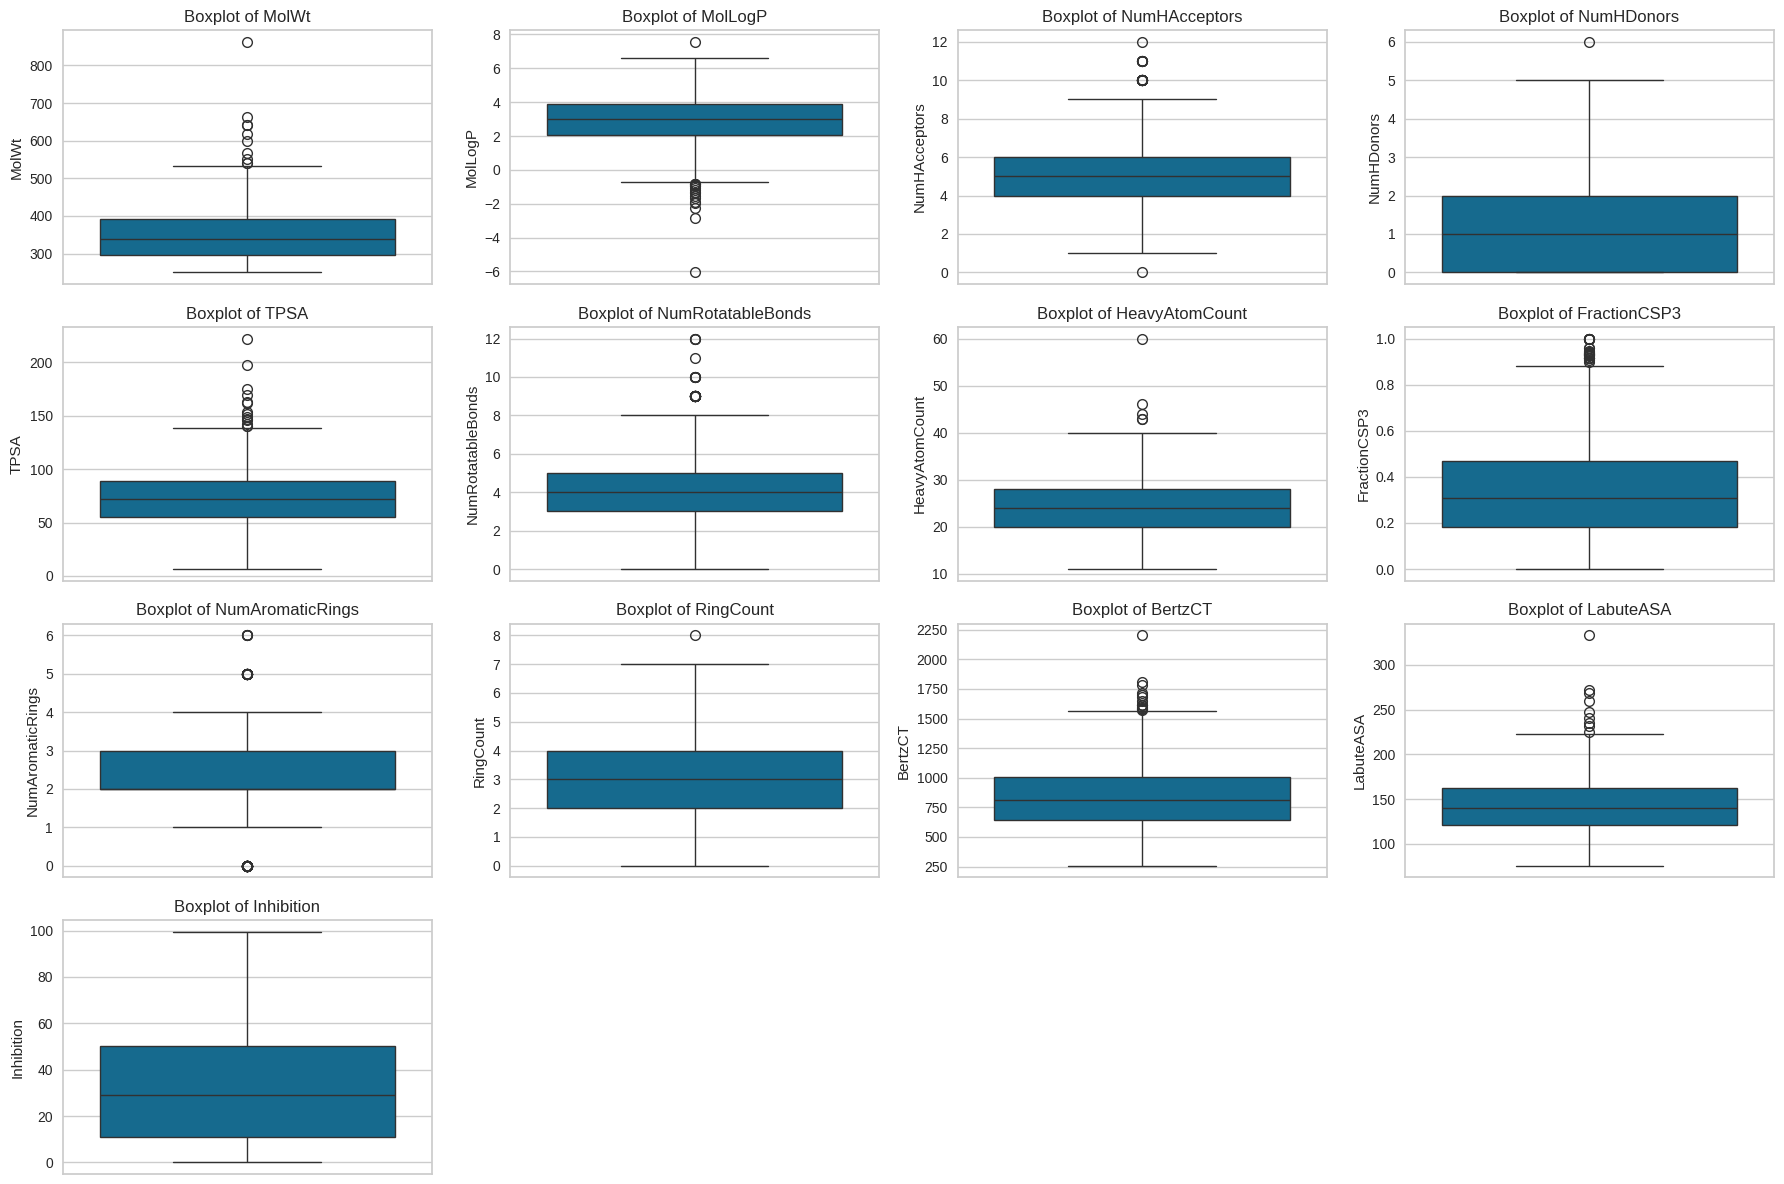

In [ ]:
# 이상치 탐색
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(18, 12))  # 변수 수에 따라 nrows/ncols 조정
axes = axes.flatten()

for i, col in enumerate(rdkit_df.columns[:len(axes)]):  # 변수 수가 subplot보다 많으면 조절
    sns.boxplot(y=rdkit_df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# 이상치 탐지
# 이상치의 개수가 10% 미만이기 때문에 이상치를 그대로 유지한 채로 모델 처리해도 괜찮을 것 같음.
Q1 = rdkit_df.quantile(0.25)
Q3 = rdkit_df.quantile(0.75)
IQR = Q3 - Q1

# 이상치 여부 판단 (True/False)
outliers = (rdkit_df < (Q1 - 1.5 * IQR)) | (rdkit_df > (Q3 + 1.5 * IQR))

# 이상치 개수 출력
outlier_counts = outliers.sum().sort_values(ascending=False)
print("이상치 개수:\n", outlier_counts)

이상치 개수:
 NumAromaticRings     109
NumRotatableBonds     37
FractionCSP3          27
NumHAcceptors         24
MolLogP               18
BertzCT               15
TPSA                  14
MolWt                 10
LabuteASA              9
HeavyAtomCount         5
NumHDonors             1
RingCount              1
Inhibition             0
dtype: int64


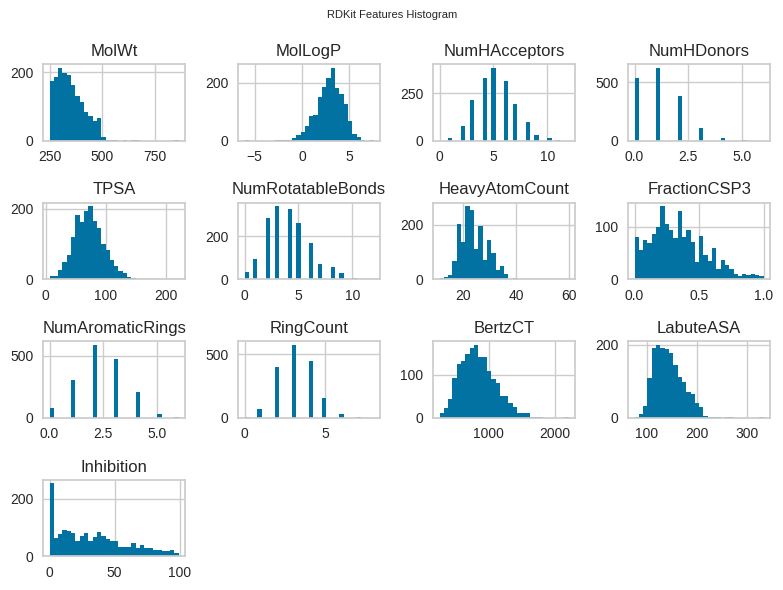

In [ ]:
# 각 피처의 분포 시각화
# 타겟값이 0 근처에 편중 -> 편향된 분포
# 로그 변환보다는 정규화 또는 RobustScaler 같은 스케일링을 적용하고 트리 기반 모델(XGBoost, CatBoost)가 유리할 것으로 예상
rdkit_df.hist(figsize=(8,6), bins=30)
plt.suptitle("RDKit Features Histogram", fontsize=8)
plt.tight_layout()
plt.show()

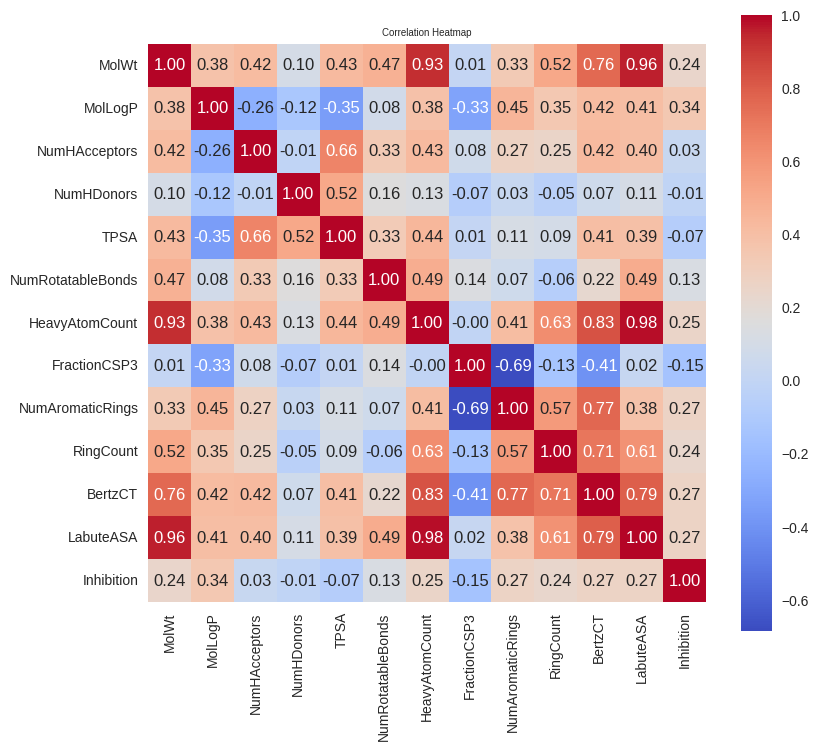

In [ ]:
# 상관관계 분석
# 상관계수가 높은 피처 간에는 중복 정보일 수 있으므로 PCA를 적용해보는 것도 좋을 것 같음.
corr = rdkit_df.corr()

plt.figure(figsize=(9,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap="coolwarm", square=True)
plt.title('Correlation Heatmap',fontsize=7)
plt.show()

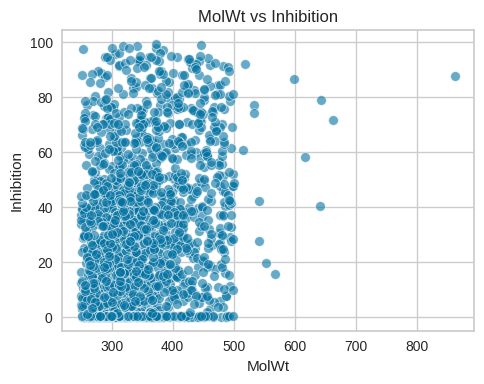

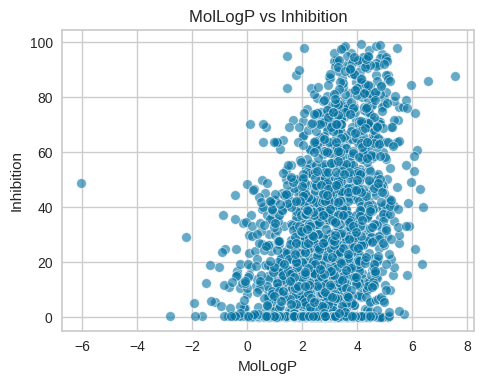

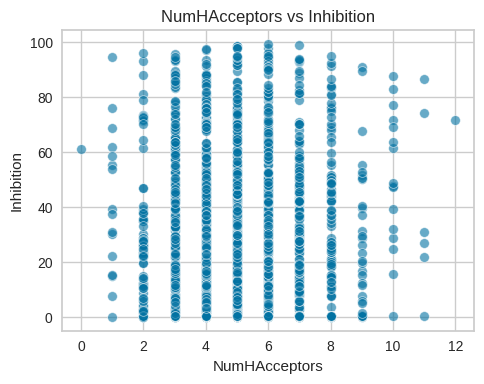

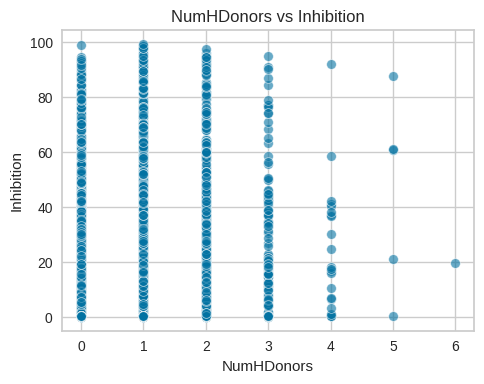

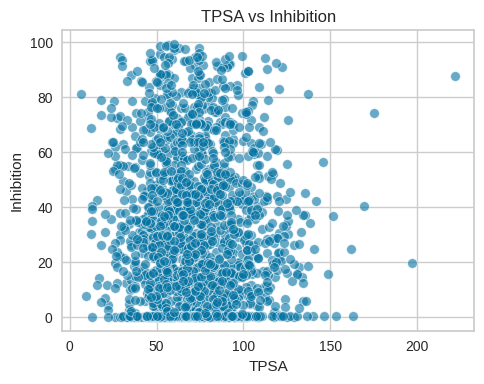

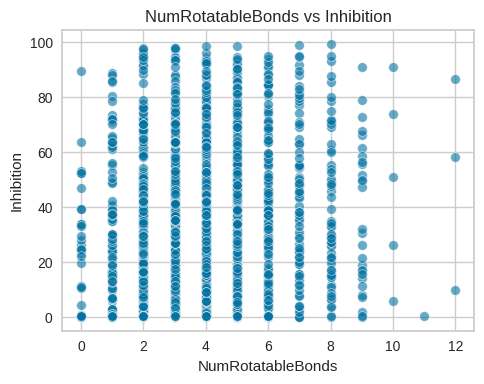

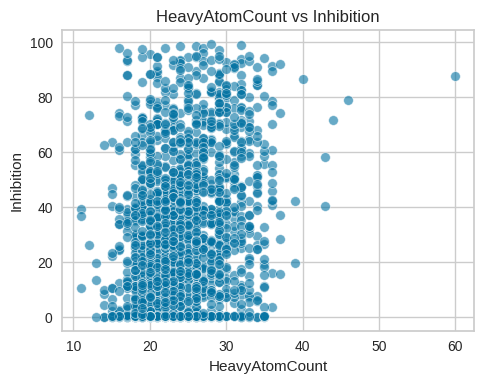

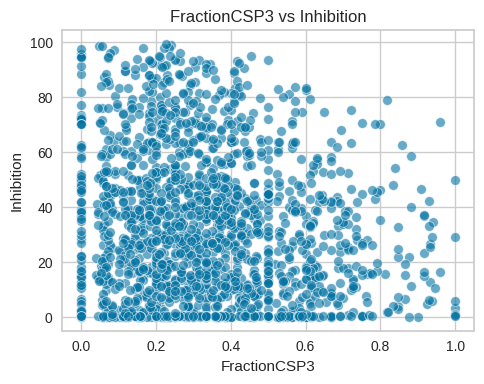

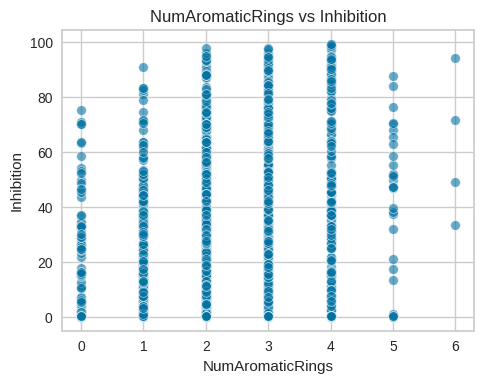

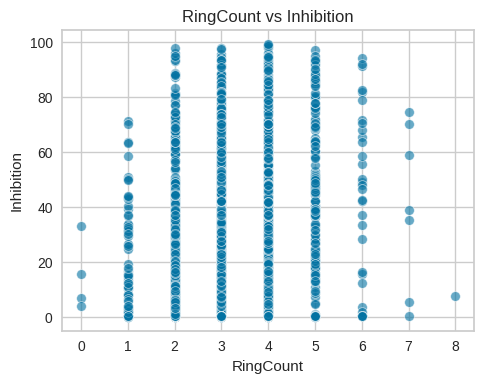

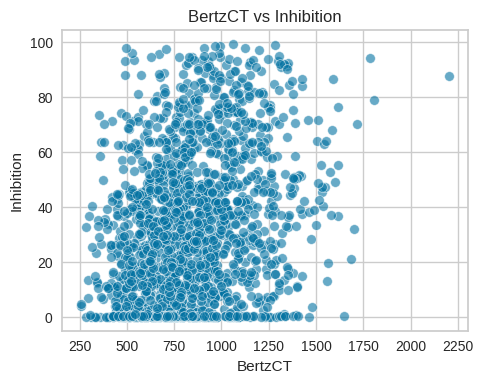

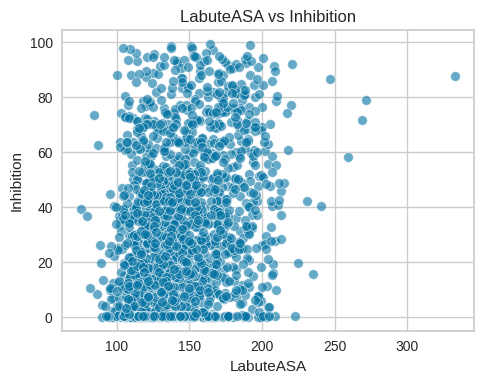

In [ ]:
# 타겟과의 관계 시각화
# 선형/비선형 관계가 보이는 것 같지는 않음.
# 분류처럼 구간별 특성이 있을 수도 있으니 클러스터링(KMeans) 활용해보는 것도 좋을 것으로 예상.
# 전반적으로 복합적인 상호작용을 모델이 학습하게 하는 게 중요할 것으로 예상됨 => 트리 기반 모델을 강화
features = rdkit_df.columns.drop("Inhibition")

for col in features:
    plt.figure(figsize=(5, 4))
    sns.scatterplot(data=rdkit_df, x=col, y="Inhibition", alpha=0.6)
    plt.title(f"{col} vs Inhibition")
    plt.xlabel(col)
    plt.ylabel("Inhibition")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# 분포 왜도/정규성 확인
# 분포가 꽤 비대칭인 피처들이 존재 -> 왜도가 높은 피처에는 log1p 또는 sqrt 변환을 검토 => XGBoost, CatBoost는 스케일에 민감하지 않아서 큰 문제는 아님.
skewness = rdkit_df.drop(columns=["Inhibition"]).apply(skew).sort_values(ascending=False)
print(skewness)

MolWt                0.931698
NumHDonors           0.799788
LabuteASA            0.740550
HeavyAtomCount       0.669505
FractionCSP3         0.635998
NumRotatableBonds    0.574763
BertzCT              0.562773
TPSA                 0.508887
NumHAcceptors        0.333675
RingCount            0.312350
NumAromaticRings     0.092557
MolLogP             -0.540412
dtype: float64


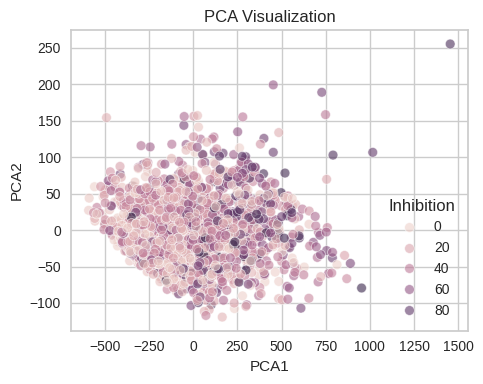

In [ ]:
# PCA 2D 변환
# Inhibition 값이 분자 구조의 선형 조합으로 설명되지 않음.
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rdkit_df)

pca_df = pd.DataFrame(pca_result, columns=["PCA1", "PCA2"])
pca_df["Inhibition"] = train["Inhibition"].values

plt.figure(figsize=(5, 4))
sns.scatterplot(data=pca_df, x="PCA1", y="PCA2", hue="Inhibition", alpha=0.6)
plt.title("PCA Visualization")
plt.grid(True)
plt.tight_layout()
plt.show()

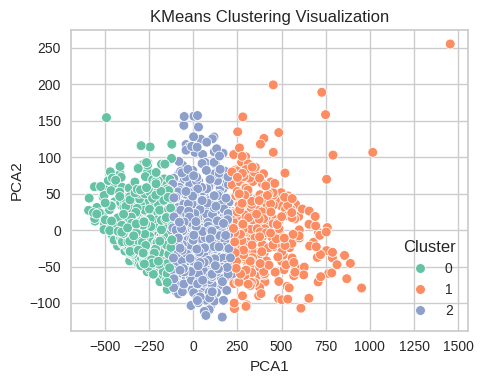

In [ ]:
# KMeans 클러스터링 시각화
# 뚜렷하게 보임. 구조 기반 분류가 도움이 될 것으로 예상. => 이 구조를 활용해 클러스터 번호를 새로운 feature로 추가하면 모델의 성능이 개선될 가능성이 있음.
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(rdkit_df)

cluster_df = pd.DataFrame(pca_result, columns = ["PCA1","PCA2"])
cluster_df["Cluster"] = clusters

plt.figure(figsize=(5, 4))
sns.scatterplot(data=cluster_df, x="PCA1", y="PCA2", hue="Cluster", palette="Set2", s=50)
plt.title("KMeans Clustering Visualization")
plt.grid(True)
plt.tight_layout()
plt.show()